##EDA##

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import geopandas as gpd
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

In [ ]:
# Load the dataset
data = pd.read_csv('GlobalWeatherRepository.csv')

In [ ]:
# Display basic info
print("Data shape:", data.shape)
print(data.head())

Data shape: (62753, 41)
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1               

# 1. Data Cleaning & Preprocessing #


In [ ]:
# Convert last_updated to datetime and sort the data
data['last_updated'] = pd.to_datetime(data['last_updated'], errors='coerce')
data.sort_values(by='last_updated', inplace=True)

In [ ]:
# Extract additional time features for time series analysis
data['year'] = data['last_updated'].dt.year
data['month'] = data['last_updated'].dt.month
data['day'] = data['last_updated'].dt.day
data['hour'] = data['last_updated'].dt.hour

##Missing values##

In [ ]:
# Check for missing values BEFORE imputation
missing_before = data[num_cols].isnull().sum()
print("Missing Values Before KNN Imputation:")
print(missing_before[missing_before > 0].sort_values(ascending=False))

Missing Values Before KNN Imputation:
Series([], dtype: int64)


In [ ]:
# Impute missing numerical values using KNN Imputer
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
imputer = KNNImputer(n_neighbors=5)
data[num_cols] = imputer.fit_transform(data[num_cols])

In [ ]:
# Check for missing values AFTER imputation
missing_after = pd.DataFrame(data[num_cols]).isnull().sum()
print("\nMissing Values After KNN Imputation:")
print(missing_after[missing_after > 0].sort_values(ascending=False))


Missing Values After KNN Imputation:
Series([], dtype: int64)


In [ ]:
# Create comparison DataFrame
missing_df = pd.DataFrame({
    'Before': missing_before,
    'After': missing_after
}).sort_values(by='Before', ascending=False)

# Filter only columns that had missing values before
missing_filtered = missing_df[missing_df['Before'] > 0]

# Plot only if there's something to show
if not missing_filtered.empty:
    missing_filtered.plot(kind='bar', figsize=(12, 6), title='Missing Values Before vs After Imputation')
    plt.ylabel('Missing Count')
    plt.show()
else:
    print("✅ No missing values detected before imputation — nothing to plot!")

✅ No missing values detected before imputation — nothing to plot!


As we can see theres no problem with missing values ! which is good :)

##Normalise Data##

In [ ]:

# Normalize selected numerical columns using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[num_cols])
data[num_cols] = scaled_features

In [ ]:
# Check if the normalization worked: mean ≈ 0, std ≈ 1
means = data[num_cols].mean().round(2)
stds = data[num_cols].std().round(2)

norm_check = pd.DataFrame({
    'Mean': means,
    'Standard Deviation': stds
})

print("🔍 Post-Normalization Stats (should be ~0 mean, ~1 std):")
display(norm_check.sort_values(by='Standard Deviation', ascending=False))


🔍 Post-Normalization Stats (should be ~0 mean, ~1 std):


,Mean,Standard Deviation
latitude,-0.0,1.0
longitude,-0.0,1.0
last_updated_epoch,-0.0,1.0
temperature_celsius,-0.0,1.0
temperature_fahrenheit,-0.0,1.0
wind_mph,-0.0,1.0
wind_kph,0.0,1.0
wind_degree,-0.0,1.0
pressure_mb,0.0,1.0
pressure_in,0.0,1.0


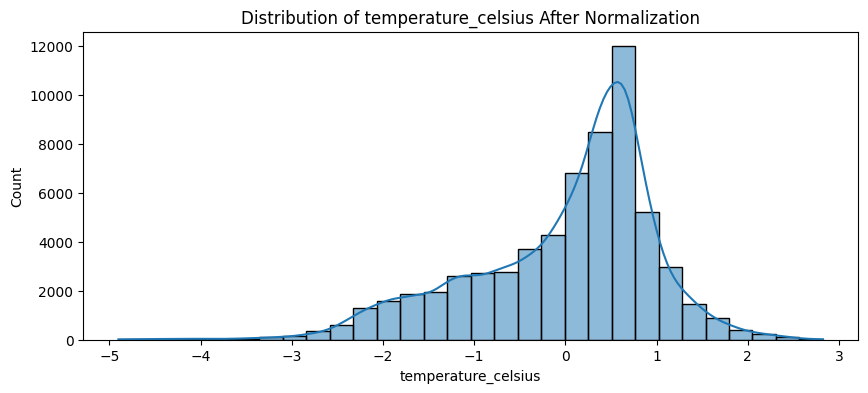

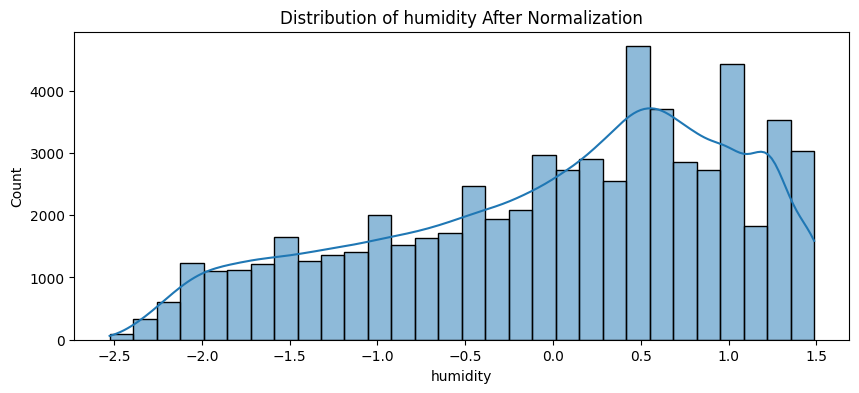

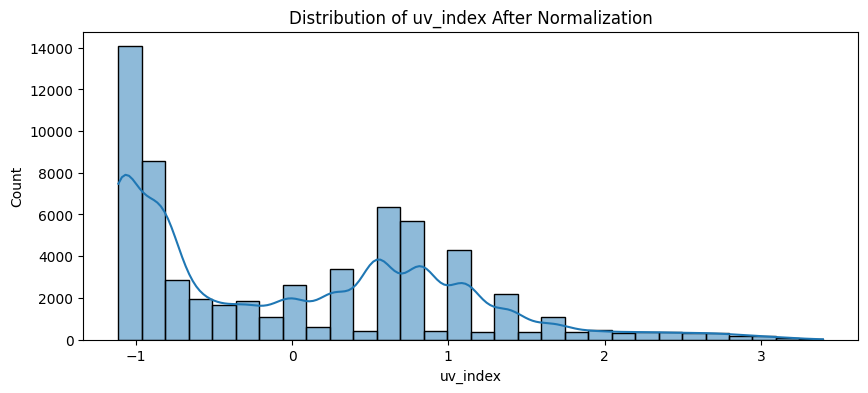

In [ ]:
# Plot distribution of some features before vs after normalization
import matplotlib.pyplot as plt
import seaborn as sns


# orig_data = pd.read_csv("Global Weather Repository.csv")
# orig_data = orig_data[num_cols].copy()

# Pick a few features to visualize
features_to_check = ['temperature_celsius', 'humidity', 'uv_index']

# Plot histograms after normalization
for col in features_to_check:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"Distribution of {col} After Normalization")
    plt.xlabel(col)
    plt.show()


# 2. Advanced Exploratory Data Analysis #

##heatmap##

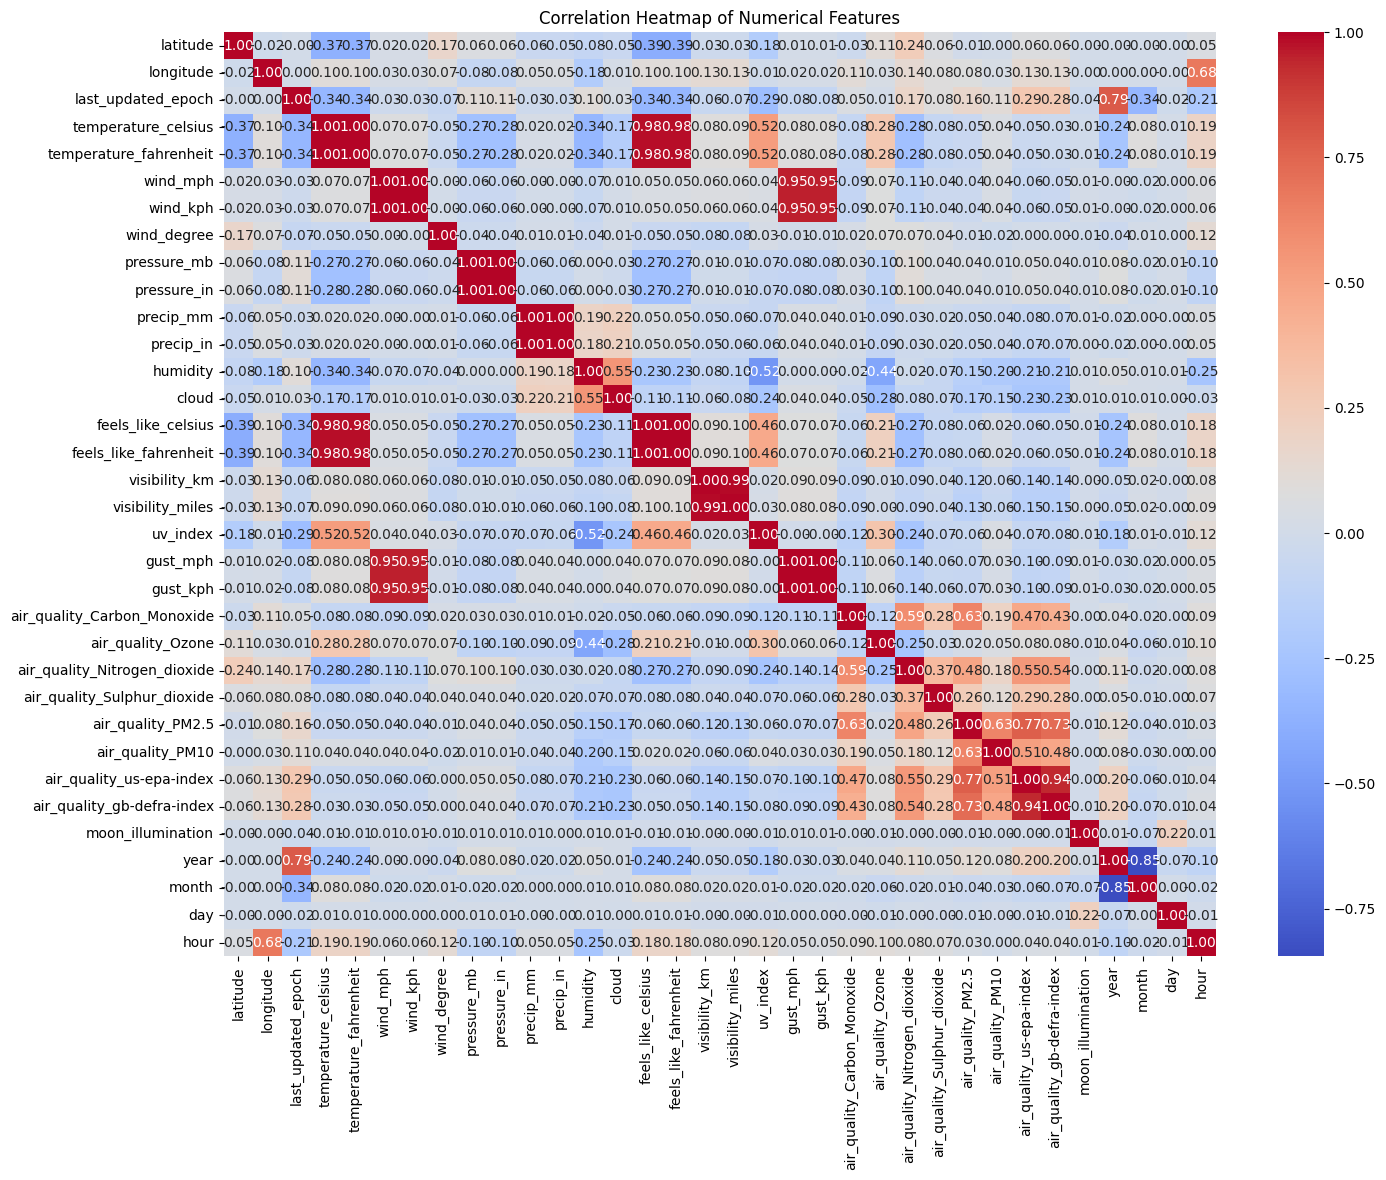

In [ ]:
# (a) Correlation heatmap for numerical features
plt.figure(figsize=(16, 12))
corr = data[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

##Outlier detection##

In [ ]:
# (b) Outlier detection using Isolation Forest on temperature (celsius) and precipitation
# Adjust contamination rate as needed
features_for_anomaly = data[['temperature_celsius', 'precip_mm']].copy()
iso_forest = IsolationForest(contamination=0.01, random_state=42)
data['anomaly'] = iso_forest.fit_predict(features_for_anomaly)

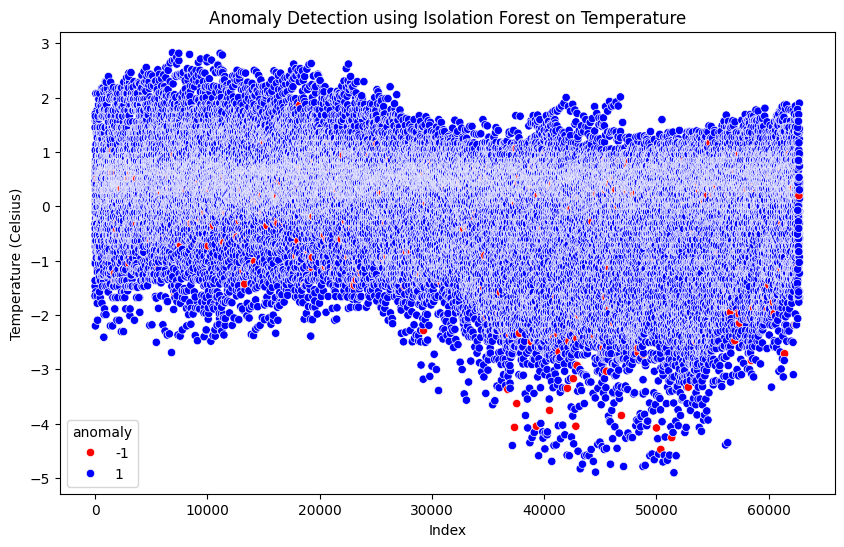

In [ ]:
# Visualize anomalies vs. normal observations
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data.index, y='temperature_celsius', hue='anomaly', data=data, palette={1:'blue', -1:'red'})
plt.title("Anomaly Detection using Isolation Forest on Temperature")
plt.xlabel("Index")
plt.ylabel("Temperature (Celsius)")
plt.show()

 Verify the Distribution of Anomalies

In [ ]:
# Count of anomalies vs. normal points
anomaly_counts = data['anomaly'].value_counts()
print("Anomaly Counts:")
print(anomaly_counts)

Anomaly Counts:
anomaly
 1    62125
-1      628
Name: count, dtype: int64


 Investigate Anomalies in More Detail

In [ ]:
# Get the rows where anomalies were detected
anomalies = data[data['anomaly'] == -1]
print(f"Anomalies detected at indices: {anomalies.index.tolist()}")
print(anomalies[['temperature_celsius', 'precip_mm']].head())

Anomalies detected at indices: [317, 219, 746, 935, 1120, 1324, 1341, 1439, 1586, 1580, 1827, 1754, 1869, 1967, 1953, 2037, 1970, 2162, 2434, 2349, 2439, 2649, 2616, 2865, 2891, 3049, 3031, 3273, 3280, 3128, 3226, 3263, 3394, 3475, 3639, 3725, 3724, 4042, 4726, 4852, 5025, 5059, 4991, 5220, 5254, 5300, 5716, 5683, 5685, 5946, 5954, 6080, 6229, 6176, 6219, 6285, 6301, 6286, 6330, 6424, 6500, 6550, 6495, 6671, 6770, 6633, 6726, 6860, 7122, 7072, 7095, 7112, 7243, 7228, 7355, 7591, 7606, 7631, 7863, 7864, 7881, 8072, 8137, 8164, 8488, 8360, 8587, 8662, 8803, 9075, 9020, 9225, 9130, 9340, 9437, 9519, 9582, 9696, 9820, 10093, 10355, 10384, 10309, 10635, 10571, 10967, 11175, 11302, 11449, 11527, 11488, 11553, 11668, 11754, 11742, 11720, 11820, 11956, 12058, 12064, 12151, 12448, 12534, 12476, 12643, 12665, 12864, 12859, 12900, 13085, 13080, 13210, 13170, 13399, 13521, 13337, 13570, 13753, 14089, 14229, 14231, 14567, 14616, 14595, 14740, 14814, 14811, 14984, 15009, 15006, 14912, 15152, 15120, 

The anomaly rate is quite low. So there is no need to adjust the Contamination Rate.

##Time Series##

In [ ]:

# (c) Time series decomposition for a single location (e.g., Kabul)
city = "Kabul"
city_data = data[data['location_name'] == city].copy()

In [ ]:
# Ensure data is sorted and set datetime as index
city_data.set_index('last_updated', inplace=True)
city_data = city_data.asfreq('D')

In [ ]:
# Fill any gaps via forward fill
city_data['temperature_celsius'] = city_data['temperature_celsius'].fillna(method='ffill')

<ipython-input-14-b58350fb68ae>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_data['temperature_celsius'] = city_data['temperature_celsius'].fillna(method='ffill')


In [ ]:
# Decompose the temperature time series
result = seasonal_decompose(city_data['temperature_celsius'], model='additive', period=7)  # weekly seasonality assumed

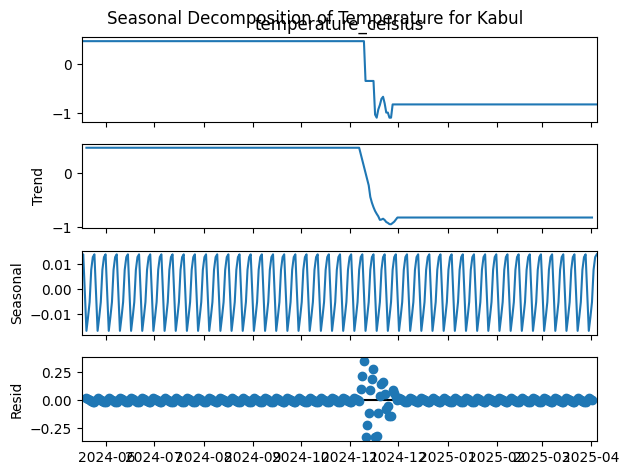

In [ ]:
# Plot the decomposition
result.plot()
plt.suptitle(f"Seasonal Decomposition of Temperature for {city}")
plt.show()

# 3. In-depth Analyses#

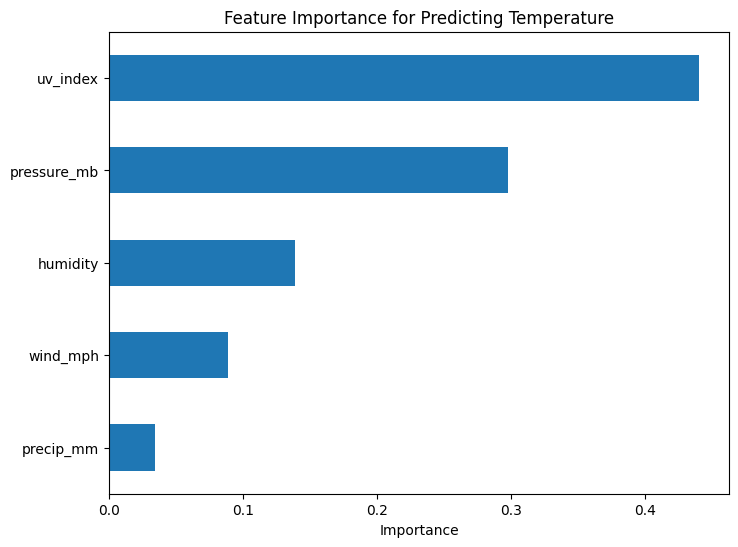

In [ ]:
# (a) Feature Importance using a Random Forest as a proxy
from sklearn.ensemble import RandomForestRegressor

# Example: Predicting temperature from a set of features
features = ['wind_mph', 'pressure_mb', 'precip_mm', 'humidity', 'uv_index']
# Remove rows with missing features if any remain
rf_data = data.dropna(subset=features + ['temperature_celsius'])
X = rf_data[features]
y = rf_data['temperature_celsius']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance
importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance for Predicting Temperature")
plt.xlabel("Importance")
plt.show()


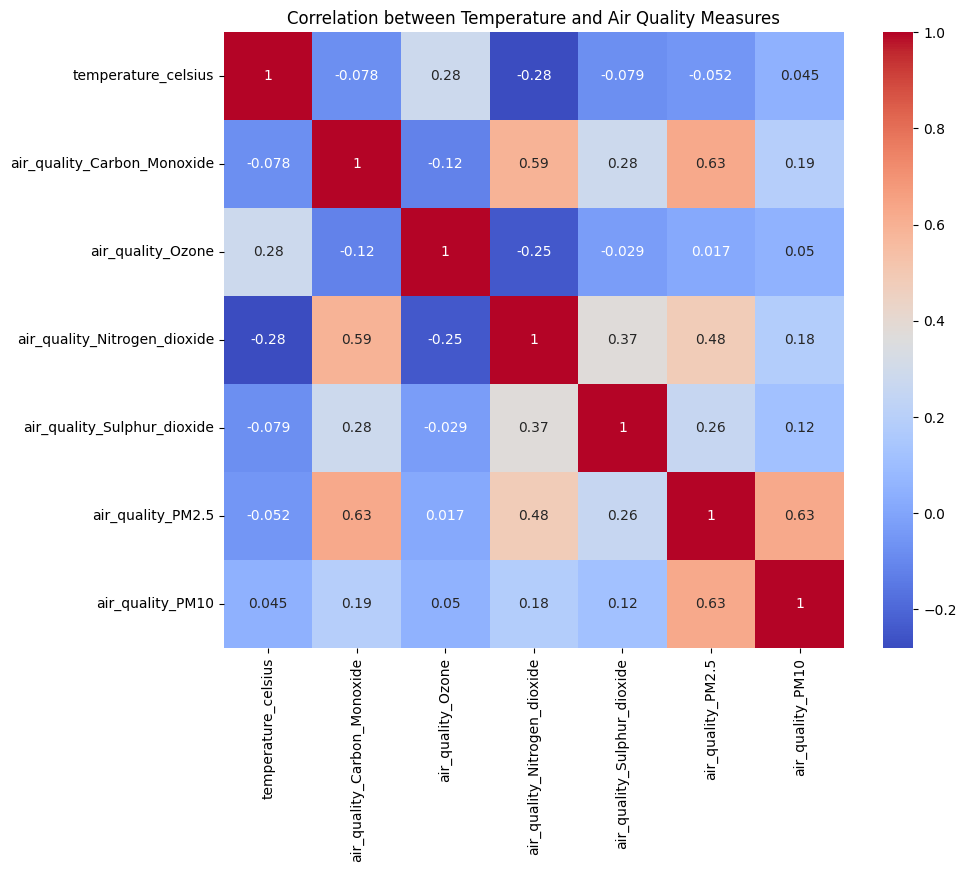

In [ ]:
# (b) Environmental Impact Analysis: Correlation between air quality and temperature
air_quality_features = ['air_quality_Carbon_Monoxide', 'air_quality_Ozone',
                        'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
                        'air_quality_PM2.5', 'air_quality_PM10']
env_data = data[['temperature_celsius'] + air_quality_features]
env_corr = env_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(env_corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Temperature and Air Quality Measures")
plt.show()

#Models#

##Preprocessing##

In [ ]:
# ================== Imports ==================
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# ================== Load & Prepare Data ==================
data = pd.read_csv("GlobalWeatherRepository.csv")
target_col = 'temperature_celsius'

In [ ]:
print(data.head()) #verify

       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  Partly cloudy

In [ ]:

# Convert 'HH:MM AM/PM' to minutes after midnight (with fallback for non-time strings)
def time_to_minutes(series):
    def parse_time(t):
        try:
            dt = pd.to_datetime(t, format='%I:%M %p')
            return dt.hour * 60 + dt.minute
        except:
            return np.nan
    return series.apply(parse_time)

# Handle time-related columns
for col in ['sunrise', 'sunset', 'moonrise', 'moonset']:
    if col in data.columns:
        data[col] = time_to_minutes(data[col])
        data[col] = data[col].fillna(data[col].median())

# Encode moon phase
if 'moon_phase' in data.columns:
    data['moon_phase'] = data['moon_phase'].astype('category').cat.codes

# Convert wind direction to angle
direction_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5,
    'SE': 135, 'SSE': 157.5, 'S': 180, 'SSW': 202.5, 'SW': 225,
    'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}
if 'wind_direction' in data.columns:
    data['wind_direction'] = data['wind_direction'].map(direction_map)

# Encode location_name using mean target encoding
if 'location_name' in data.columns:
    location_temp_mean = data.groupby('location_name')[target_col].mean()
    data['location_name_encoded'] = data['location_name'].map(location_temp_mean)
    data.drop(columns=['location_name'], inplace=True)


In [ ]:
# ================== Drop problematic features ==================
# Drop temperature-related features
data = data.drop(columns=['temperature_fahrenheit', 'feels_like_celsius', 'feels_like_fahrenheit'])

In [ ]:
# ================== Train-Test Split ==================
X = data.drop(columns=[target_col])  # Drop target column from features
y = data[target_col]  # Define target column
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# ================== Encoding and Scaling ==================
def encode_and_scale(X_train, X_val, X_test):
    full_data = pd.concat([X_train, X_val, X_test], keys=['train', 'val', 'test'])

    for col in full_data.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        full_data[col] = le.fit_transform(full_data[col].astype(str))

    X_train = full_data.xs('train')
    X_val   = full_data.xs('val')
    X_test  = full_data.xs('test')

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled

# Apply encoding and scaling
X_train_scaled, X_val_scaled, X_test_scaled = encode_and_scale(X_train, X_val, X_test)

##Model 1: Random Forest##

In [ ]:
# ================== Model 1: Random Forest ==================
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_val_pred = rf_model.predict(X_val_scaled)

rf_mae = mean_absolute_error(y_val, rf_val_pred)
rf_mse = mean_squared_error(y_val, rf_val_pred)
rf_r2  = r2_score(y_val, rf_val_pred)

##Model 2 : XGBoost##

In [ ]:
# ================== Model 2: XGBoost ==================
xgb_model = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train_scaled, y_train)
xgb_val_pred = xgb_model.predict(X_val_scaled)

xgb_mae = mean_absolute_error(y_val, xgb_val_pred)
xgb_mse = mean_squared_error(y_val, xgb_val_pred)
xgb_r2  = r2_score(y_val, xgb_val_pred)

##Model 3 : LSTM -Deep learning##

In [ ]:
# ================== Model 3: LSTM ==================
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm   = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

# Setup callbacks
checkpoint_path = "best_lstm_model.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
]

lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))

# Train LSTM
history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_lstm, y_val),
    callbacks=callbacks,
    verbose=1
)

if os.path.exists(checkpoint_path):
    lstm_model.load_weights(checkpoint_path)

lstm_val_pred = lstm_model.predict(X_val_lstm).flatten()
lstm_mae = mean_absolute_error(y_val, lstm_val_pred)
lstm_mse = mean_squared_error(y_val, lstm_val_pred)
lstm_r2  = r2_score(y_val, lstm_val_pred)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1373/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 244.8575

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 244.7613 - val_loss: 19.1769
Epoch 2/50
1359/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.5931

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 20.5672 - val_loss: 10.1538
Epoch 3/50
1365/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.1467

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 14.1432 - val_loss: 7.7204
Epoch 4/50
1367/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.3664

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 12.3649 - val_loss: 6.7508
Epoch 5/50
1371/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.2786

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 11.2783 - val_loss: 5.9950
Epoch 6/50
1359/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.7901

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 10.7871 - val_loss: 5.7340
Epoch 7/50
1370/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.2154

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 10.2151 - val_loss: 5.4029
Epoch 8/50
1360/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5547

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 9.5551 - val_loss: 5.2887
Epoch 9/50
1369/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4122

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 9.4115 - val_loss: 5.1122
Epoch 10/50
1368/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1107

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 9.1100 - val_loss: 4.9276
Epoch 11/50
1360/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8624

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 8.8619 - val_loss: 4.8683
Epoch 12/50
1372/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6134

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 8.6133 - val_loss: 4.4957
Epoch 13/50
1362/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2630

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.2630 - val_loss: 4.4214
Epoch 14/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 8.1395 - val_loss: 4.4474
Epoch 15/50
1370/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0485

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 8.0483 - val_loss: 4.3032
Epoch 16/50
1369/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8568

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.8568 - val_loss: 4.2528
Epoch 17/50
1371/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7558

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.7557 - val_loss: 4.1844
Epoch 18/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.5467 - val_loss: 4.2891
Epoch 19/50
1368/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2609

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.2611 - val_loss: 4.1408
Epoch 20/50
1368/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2084

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7.2083 - val_loss: 4.0587
Epoch 21/50
1371/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1293

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 7.1291 - val_loss: 4.0211
Epoch 22/50
1371/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0614

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.0612 - val_loss: 3.9879
Epoch 23/50
1369/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9194

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6.9193 - val_loss: 3.9842
Epoch 24/50
1369/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8811

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6.8808 - val_loss: 3.9622
Epoch 25/50
1363/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7057

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6.7055 - val_loss: 3.9171
Epoch 26/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.6361 - val_loss: 3.9262
Epoch 27/50
1364/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4547

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.4547 - val_loss: 3.8904
Epoch 28/50
1360/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4213

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.4213 - val_loss: 3.8081
Epoch 29/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.2914 - val_loss: 3.8086
Epoch 30/50
1372/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3012

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.3011 - val_loss: 3.7498
Epoch 31/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 6.1430 - val_loss: 3.7532
Epoch 32/50
1363/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0820

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 6.0818 - val_loss: 3.7380
Epoch 33/50
1359/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0057

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.0053 - val_loss: 3.6782
Epoch 34/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.9333 - val_loss: 3.7395
Epoch 35/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.7781 - val_loss: 3.6913
Epoch 36/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.7731 - val_loss: 3.6800
Epoch 37/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 5.8080 - val_loss: 3.6879
Epoch 38/50
1370/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6948

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.6946 - val_loss: 3.6154
Epoch 39/50
1360/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5821

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.5820 - val_loss: 3.6129
Epoch 40/50
1358/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5239

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.5237 - val_loss: 3.5942
Epoch 41/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4671

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.4670 - val_loss: 3.5629
Epoch 42/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.4788 - val_loss: 3.5851
Epoch 43/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 5.4360 - val_loss: 3.6016
Epoch 44/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 5.3208 - val_loss: 3.5905
Epoch 45/50
1361/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3416

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.3413 - val_loss: 3.5425
Epoch 46/50
1365/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1663

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.1660 - val_loss: 3.5052
Epoch 47/50
1366/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1336

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.1338 - val_loss: 3.4781
Epoch 48/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.1152 - val_loss: 3.4999
Epoch 49/50
1361/1373 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0314

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 5.0316 - val_loss: 3.4175
Epoch 50/50
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.0187 - val_loss: 3.4985
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


##Evaluation and Ensemble##

In [ ]:
# ================== Evaluation ==================
print("\n==== Model Comparison (Validation Set) ====")
print(f"Random Forest   - MAE: {rf_mae:.2f}, MSE: {rf_mse:.2f}, R2: {rf_r2:.2f}")
print(f"XGBoost         - MAE: {xgb_mae:.2f}, MSE: {xgb_mse:.2f}, R2: {xgb_r2:.2f}")
print(f"LSTM            - MAE: {lstm_mae:.2f}, MSE: {lstm_mse:.2f}, R2: {lstm_r2:.2f}")


==== Model Comparison (Validation Set) ====
Random Forest   - MAE: 1.17, MSE: 2.81, R2: 0.97
XGBoost         - MAE: 1.27, MSE: 3.07, R2: 0.97
LSTM            - MAE: 1.38, MSE: 3.42, R2: 0.96


In [ ]:
# ---- 1. Simple Average Ensemble ----
ensemble_simple = (rf_val_pred + xgb_val_pred + lstm_val_pred) / 3

simple_mae = mean_absolute_error(y_val, ensemble_simple)
simple_mse = mean_squared_error(y_val, ensemble_simple)
simple_r2  = r2_score(y_val, ensemble_simple)

In [ ]:
# ---- 2. Weighted Average Ensemble ----
# Inverse of MAE (lower MAE -> higher weight)
inv_mae_rf   = 1 / rf_mae
inv_mae_xgb  = 1 / xgb_mae
inv_mae_lstm = 1 / lstm_mae

# Normalize weights so they sum to 1
total_inv = inv_mae_rf + inv_mae_xgb + inv_mae_lstm
weights = {
    'rf': inv_mae_rf / total_inv,
    'xgb': inv_mae_xgb / total_inv,
    'lstm': inv_mae_lstm / total_inv
}

# Weighted prediction
ensemble_weighted = (
    weights['rf']   * rf_val_pred +
    weights['xgb']  * xgb_val_pred +
    weights['lstm'] * lstm_val_pred
)

weighted_mae = mean_absolute_error(y_val, ensemble_weighted)
weighted_mse = mean_squared_error(y_val, ensemble_weighted)
weighted_r2  = r2_score(y_val, ensemble_weighted)

In [ ]:
# ================== Ensemble Evaluation ==================
print("\n==== Ensemble Models ====")
print(f"Simple Average Ensemble   - MAE: {simple_mae:.2f}, MSE: {simple_mse:.2f}, R2: {simple_r2:.2f}")
print(f"Weighted Average Ensemble - MAE: {weighted_mae:.2f}, MSE: {weighted_mse:.2f}, R2: {weighted_r2:.2f}")
print("\nWeights used (based on inverse MAE):", weights)


==== Ensemble Models ====
Simple Average Ensemble   - MAE: 1.15, MSE: 2.54, R2: 0.97
Weighted Average Ensemble - MAE: 1.15, MSE: 2.53, R2: 0.97

Weights used (based on inverse MAE): {'rf': 0.360814312675594, 'xgb': 0.33196567921465814, 'lstm': 0.3072200081097479}


- The Simple Average Ensemble and Weighted Average Ensemble have an MAE of 1.15, MSE of 2.53/2.54, and R2 of 0.97, while the individual models (especially LSTM) have slightly higher MAEs and MSEs.
- Simple Average Ensemble and Weighted Average Ensemble both have the best MAE and MSE when compared to individual models.


#Unique Analysis#

In [ ]:
data = pd.read_csv("GlobalWeatherRepository.csv")

In [ ]:
data['date'] = pd.to_datetime(data['last_updated_epoch'], unit='s')

**Climate Analysis**

==== Climate Analysis ====


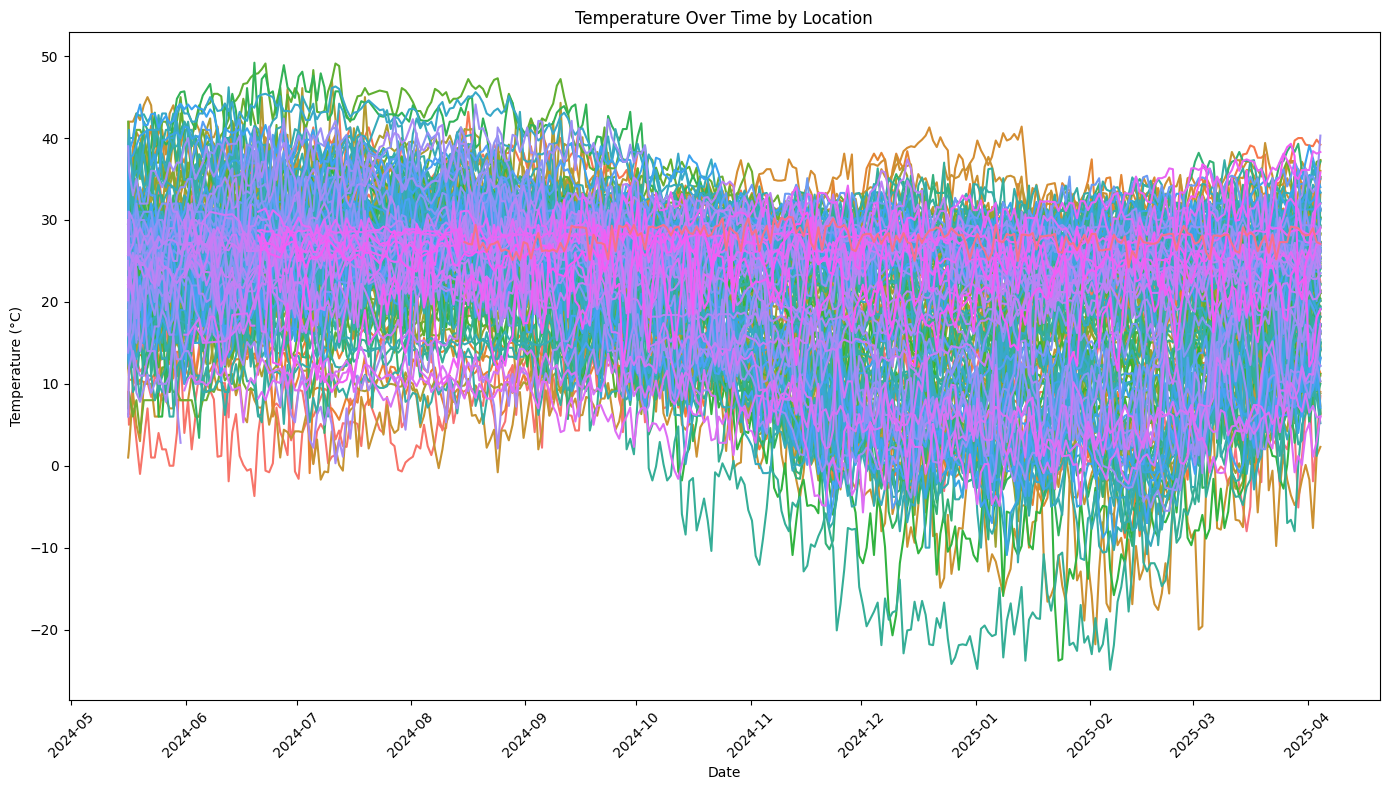

In [ ]:
print("==== Climate Analysis ====")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 8))  # Increase figure size
sns.lineplot(data=data, x='date', y='temperature_celsius', hue='location_name', errorbar=None, legend=False)
plt.title('Temperature Over Time by Location')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

**Environmental Impact**

==== Environmental Impact ====


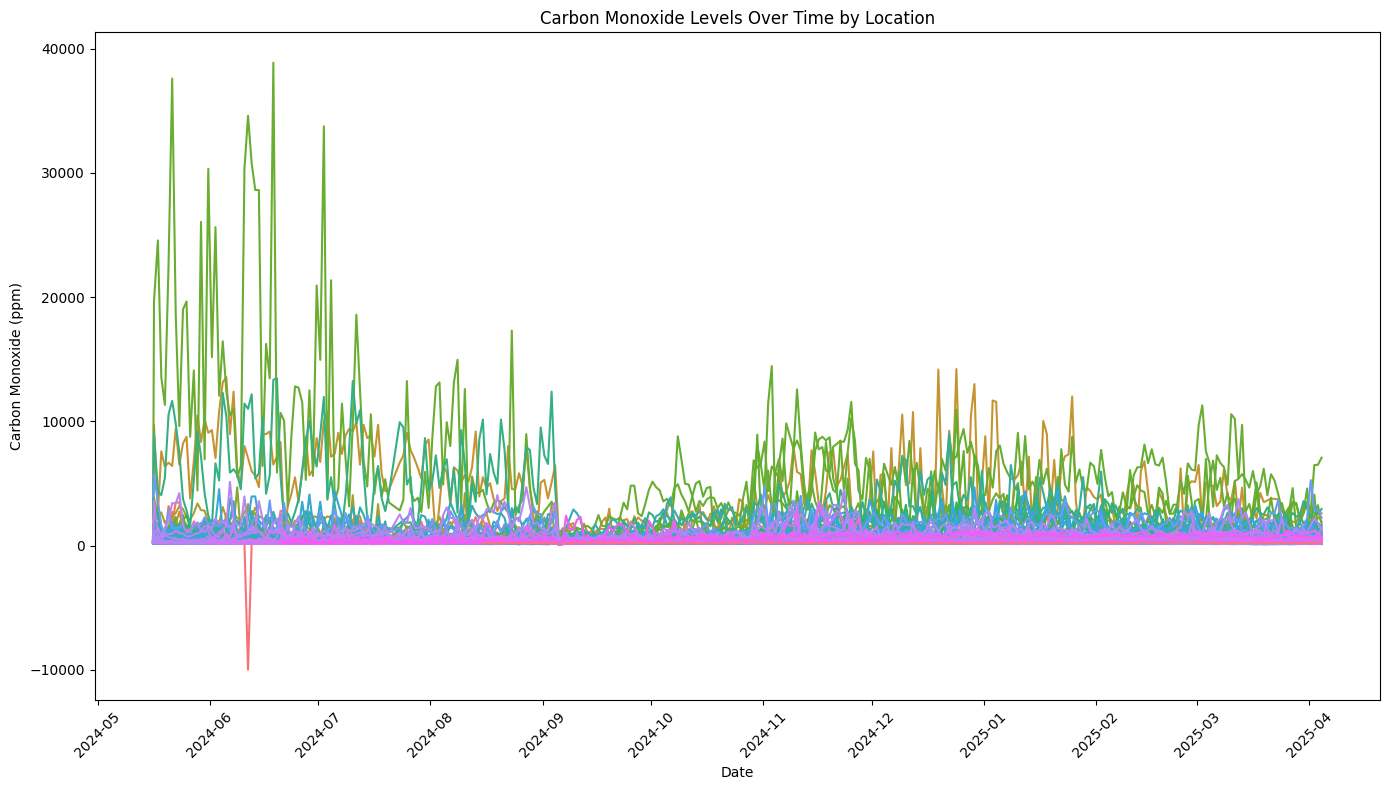

In [ ]:
print("==== Environmental Impact ====")
plt.figure(figsize=(14, 8))  # Increase figure size
sns.lineplot(data=data, x='date', y='air_quality_Carbon_Monoxide', hue='location_name', errorbar=None, legend=False)
plt.title('Carbon Monoxide Levels Over Time by Location')
plt.xlabel('Date')
plt.ylabel('Carbon Monoxide (ppm)')  # Change the label based on the feature
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()  # Adjust layout
plt.show()

**Feature Importance**

==== Feature Importance ====


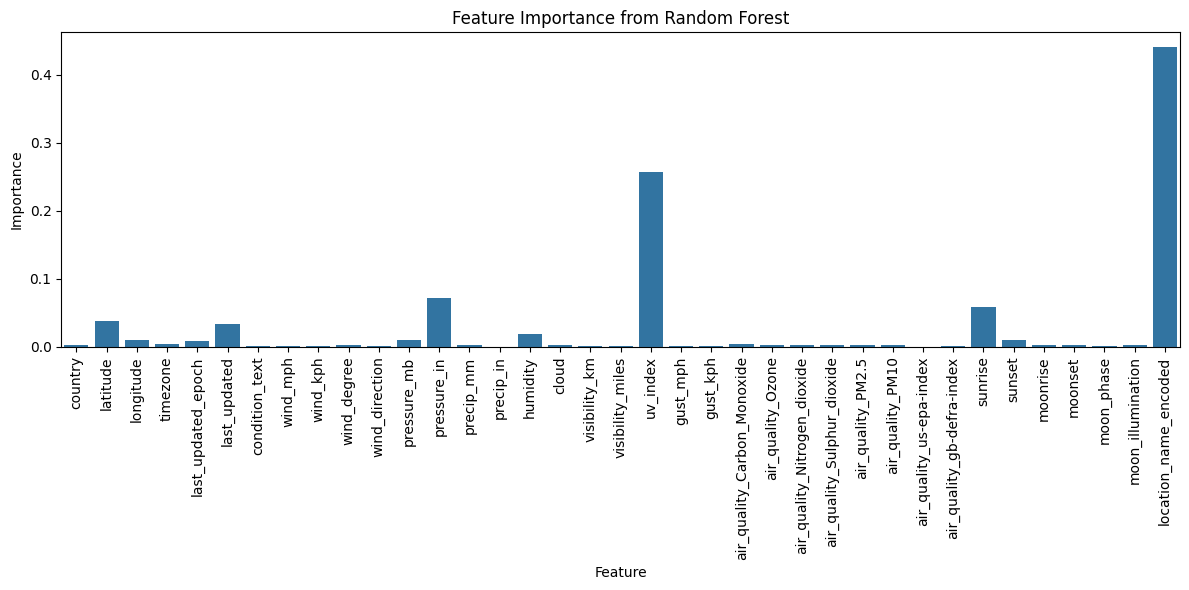

In [ ]:
print("==== Feature Importance ====")
# Feature importance from RandomForestRegressor
rf_importance = rf_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(12, 6))  # Increase figure size
sns.barplot(x=feature_names, y=rf_importance)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.tight_layout()  # Adjust layout
plt.show()

**Spatial Analysis**

==== Spatial Analysis ====


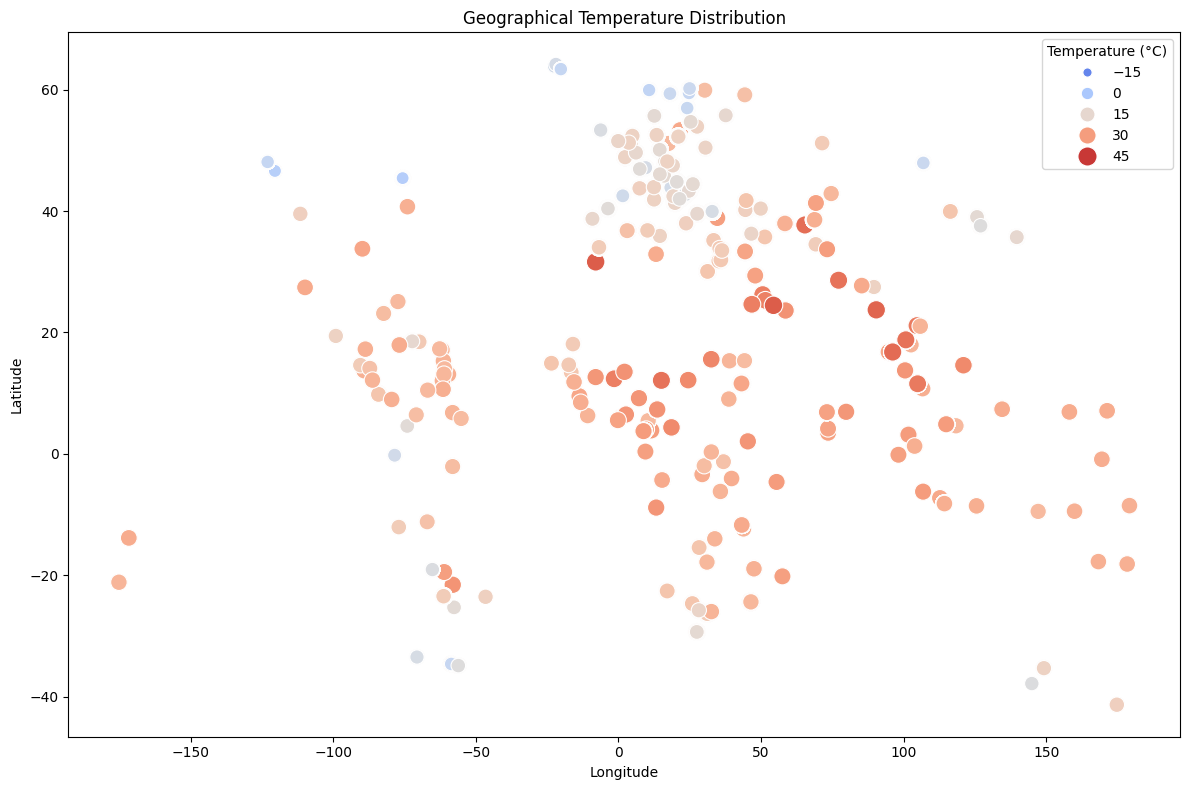

In [ ]:
print("==== Spatial Analysis ====")
plt.figure(figsize=(12, 8))  # Increase figure size
sns.scatterplot(data=data, x='longitude', y='latitude', hue='temperature_celsius', palette='coolwarm', size='temperature_celsius', sizes=(20, 200))
plt.title('Geographical Temperature Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Temperature (°C)')
plt.tight_layout()  # Adjust layout
plt.show()